# LION Classification Pipeline Notebook

This notebook demonstrates how to use the various classification pipelines in the LION package.

These are:
- Sentiment
- Topics
- Emotions
- Toxicity

NOTE: While a GPU is not a requirement, having one will greatly speed up the process of running this notebook. Google Colab and Akash are two good places to rent for reasonable rates.

## Setup

In [1]:
#install requirements
#!pip install -r cfg/requirements.txt

In [2]:
#suspend transformers warnings (you should only do this if your sure warnings can be ignored)
from transformers import logging
logging.set_verbosity_error()

2023-03-08 03:05:52.251062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#import the lion library
# initialize the lab
import modules.liontools as lion

#import lionOS

lab = lion.Lab()
lab.initialize()

# validate api access
lab.validate()

# initialize the lion ai, data, and NetSci toolkits
ai = lion.AI()
data = lion.Data()
netsci = lion.NetSci()

Lab booting up...

No GPU detected. Lab running with nominal compute.

OpenAI API credentials validated

Logging into Huggingface...

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /home/jovyan/.cache/huggingface/token
Login successful



# Data

In [4]:
# load in our data
import pandas as pd 
df = pd.read_excel('discord.xlsx')
print('row count:', len(df.index))
df.tail()

row count: 200


,username,content,mentions,time_stamp
195,saulthorin,Nope. It was a default generated logo from a t...,FINE,2023-01-07 19:40:33
196,FINE,copy that!!,saulthorin,2023-01-07 19:51:09
197,Dimpal12345,Great community admin when snapshot ote start ...,NaN,2023-01-09 23:52:34
198,pradeepbora121,watts up,NaN,2023-01-10 05:34:02
199,sandeepdas,Dear @saulthorin#7696 thanks for speaking with...,saulthorin,2023-01-10 12:36:03


## Sentiment

Using the lion AI class, we can call `analyze_sentiment()` to get the sentiment of a message. 

A few notes on sentiment analysis:
- This is currently a classification pipeline, producing a sentiment class and a probability score.
    - By default it selects only the most probable label
    - Use `top_p=False` to see all labels and scores
- There are two models available: "roberta" [default] and "bertweet".
    - [You can read more on these models here.](https://github.com/cardiffnlp/tweeteval)

In [5]:
# create our doc object containing a sampled message
doc = df.content.sample().values[0]

# run sentiment analysis with roberta all labels as output
sent = ai.analyze_sentiment(doc, model="roberta", top_p=False)

# display our result
print(doc, '\n\nRoberta Sentiment (all_labels):', sent)

# now using bertweet and only getting top p sentiment
sent = ai.analyze_sentiment(doc, model="bertweet")

# display our result
print('\nBertweet Sentiment (top_p):', sent)

If you’re around tomorrow would love to get to know you and your background https://discord.com/events/887858548921491476/1027046861149831199 

Roberta Sentiment (all_labels): [{'positive': 0.8542375, 'neutral': 0.14252569, 'negative': 0.0032368375}]

Bertweet Sentiment (top_p): [{'label': 'POS', 'score': 0.93412274}]


We can then use `get_sentiment_features()` to add top_p sentiment to our dataframe.

In [6]:
# define some test data
test = df.tail(10)

# assign the function output to a new dataframe
test_sent = ai.get_sentiment_features(test, col='content')
# view the results
test_sent.head()

,username,content,mentions,time_stamp,sent_label,sent_p_score
190,saulthorin,❤️,NaN,2023-01-04 15:21:53,positive,0.875688
191,maximus,"thanks all for reacting, I'll be working with ...",Aphilos • Pharo,2023-01-05 13:39:11,positive,0.959288
192,mines,Holla,NaN,2023-01-06 21:12:10,positive,0.569490
193,FINE,Hey Hey! Is this small case t in talentDAO a b...,NaN,2023-01-07 17:43:30,neutral,0.895461
194,FINE,https://tenor.com/view/ponder-pondering-hmm-ta...,NaN,2023-01-07 17:44:56,neutral,0.655992


Using the `get_sentiment_stats()` function of the Data class we can learn a bit more about the sentiment on our discord server.

In [7]:
data.get_sentiment_stats(test_sent)

,sent_label,count,mean,std,median,min,max
2,positive,6,0.789227,0.157997,0.841064,0.569490,0.959288
1,neutral,3,0.796240,0.124895,0.837265,0.655992,0.895461
0,negative,1,0.499417,NaN,0.499417,0.499417,0.499417


## Topics

Here will use GPT-3 to do some zeroShot topic classifcation for us using the `gpt_zShot_topic()` function of the AI class.

In [8]:
# create our doc object containing a sampled message
doc = df.content.sample().values[0]

# generate a class
zero_shot_topic = ai.gpt_zShot_topic(doc)

# display our result
print(doc, '\n\nTopic:', zero_shot_topic)

Wait are the TalentDAO community calls weekly?  Or Biweekly?  I thought they were biweekly and I thought we had one last week. Maybe I'm all messed up, Idk. 

Topic:  Scheduling Confusion


Like we previously did with sentiment, we can apply these topics to the dataframe. A simple apply function does the trick in this situation.

In [9]:
# apply the func tot the dataframe
df["zShot_Topic"] = df["content"].apply(ai.gpt_zShot_topic).str.lstrip()
df.head()

,username,content,mentions,time_stamp,zShot_Topic
0,Naiem,Completed task but still showing not eligible,NaN,2022-09-22 08:09:06,Task Completion
1,Naiem,🥲,NaN,2022-09-22 08:09:51,Mental Health
2,Naiem,any mod?,NaN,2022-09-22 08:12:07,Technology
3,Joras,Good,NaN,2022-09-22 08:22:35,Positive
4,kushal,HELLO TEAM,NaN,2022-09-22 08:31:03,Greeting


Since this uses a zero shot approach, our topics will vary significantly. Luckily, there is a function for that to. Using the `normalize_gpTopics()` function of the AI class, we can update our dataframe with parent topics for each of the topics we got using our zero shot approach. This should make things more easily for analysis.

In [10]:
# run the function
ai.normalize_gpTopics(df)
# view a sample of the outputs
df.sample(10)

,username,content,mentions,time_stamp,zShot_Topic,gpt_normalized_Topic
10,lisawocken,https://cdn.discordapp.com/attachments/9236529...,NaN,2022-09-23 13:40:51,Talent Acquisition,Recruiting
14,prateek_s,Can we still contribute so that we will be eli...,saulthorin,2022-09-26 18:17:30,Cryptocurrency Airdrop,Cryptocurrency
101,MantisClone,Is there a way to keep the sesh calendar in sy...,NaN,2022-10-21 13:32:22,Syncing Sesh Calendar with Discord Events,Calendar Management
48,FINE,"Am I at the beginning of the learning curve🤔 ,...",NaN,2022-10-03 20:29:17,Learning,Education
35,saulthorin,Today is the last day 🙂 https://twitter.com/Or...,tesa_fc,2022-09-30 15:34:35,Happiness,Emotion
97,FINE,Yes🤠,Mr.Nobody,2022-10-14 17:19:13,Positive,Optimism
163,saulthorin,<@&937868840640069702> <@&1026608264483438612>...,jringo_,2022-12-16 23:02:55,Social Media,Communication
44,FINE,I believe when we observe nature closely - we ...,iSpeakNerd.eth,2022-10-03 20:10:17,Cybersecurity,Security
123,k3nn.eth,When does this need to be done by? I should st...,saulthorin,2022-11-16 23:51:55,Time Management,Time Management
82,abrarsaifi,Morning,NaN,2022-10-13 05:15:15,Routines,Routines


Lets see how well this worked by counting the unique topics in each column.

In [11]:
# compare to topic column
print('Topic count:', df.zShot_Topic.nunique())
print('Parent topic count:', df.gpt_normalized_Topic.nunique())

Topic count: 141
Parent topic count: 95


Now we can a quick look at our new set of topics this using `value_counts()`.

In [12]:
df.gpt_normalized_Topic.value_counts()

Communication          18
Cryptocurrency         10
Organization            7
Success                 7
Attitude                6
                       ..
Calendar Management     1
Memory                  1
Event Management        1
Socializing             1
Sustainability          1
Name: gpt_normalized_Topic, Length: 95, dtype: int64

To understand the relationship between users and topics, we might consider visualizing these relatinoships on a network graph using `map_topic_net()`.

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127803 (\N{SUNFLOWER}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128029 (\N{HONEYBEE}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127803 (\N{SUNFLOWER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128029 (\N{HONEYBEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


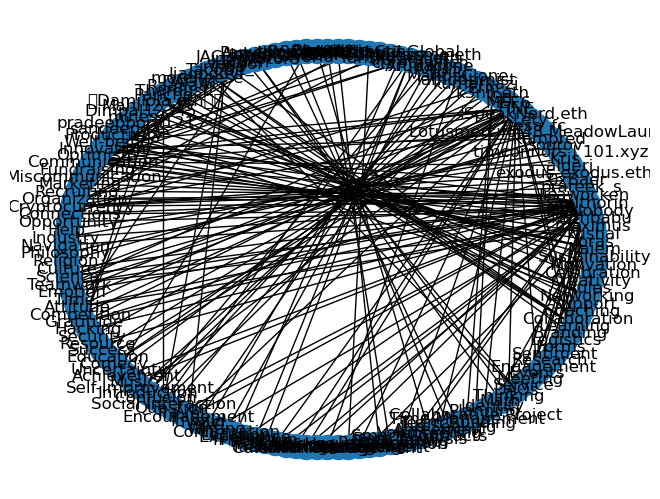

In [13]:
# #disable font related warnings
# import warnings
# warnings.simplefilter("ignore")

#run the topic network func
topic_network, G = netsci.map_topic_net(df, user_col='username', topic_col='gpt_normalized_Topic', circular=True)
#display
topic_network

Woah! Lots to unpack there. Luckily, `map_topic_network()` also returns a graph object `G` for use with other libraries. Here is an example of using `G` with `pyvis` to create an interactive network.

In [14]:
from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)
net.show('network.html')

network.html


## Emotions

The emotion classification pipeline is something we're still testing, but you can currently call it using the `AI` class with `analyze_emotion()` and get features with `get_emotion_features()`.

A few notes on emotions:
- The emotions pipeline currently defaults to a [variant of bert](https://huggingface.co/joeddav/distilbert-base-uncased-go-emotions-student) trained on the [GoEmotions](https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html) dataset from Google.
    - A [roberta](https://huggingface.co/arpanghoshal/EmoRoBERTa) model is also available
- Not talentDAO nor labDAO have have psychometrically verified this pipeline.
- By our standards, it does not yet seem like a reliable enough model for emotion in the context of DAO communaication on Discord.
- We are currently working on improving this pipeline and will push out future updates when those are ready to be implemented.
- By default the model uses a p_min of .10 to optimize for more labels across the dataset, but you can turn this up to increase reliability at the expense of less labels.

In [15]:
# create our doc object containing a sampled message
doc = df.content.sample().values[0]

# run sentiment analysis with roberta all labels as output
emo = ai.analyze_emotion(doc, p_min=.10)

# display our result
print(doc, '\n\nEmotion:', emo)

Thanks for call❤️ 

Emotion: [{'label': 'gratitude', 'score': 0.37690502405166626}]


In [16]:
# assign the function output to a new dataframe
test_emo = ai.get_emotion_features(test_sent, col='content')
# view the results
test_emo.head()

,username,content,mentions,time_stamp,sent_label,sent_p_score,emo_label,emo_p_score
190,saulthorin,❤️,NaN,2023-01-04 15:21:53,positive,0.875688,amusement,0.151996
191,maximus,"thanks all for reacting, I'll be working with ...",Aphilos • Pharo,2023-01-05 13:39:11,positive,0.959288,gratitude,0.499964
192,mines,Holla,NaN,2023-01-06 21:12:10,positive,0.569490,amusement,0.170918
193,FINE,Hey Hey! Is this small case t in talentDAO a b...,NaN,2023-01-07 17:43:30,neutral,0.895461,curiosity,0.413941
194,FINE,https://tenor.com/view/ponder-pondering-hmm-ta...,NaN,2023-01-07 17:44:56,neutral,0.655992,curiosity,0.226724


## Toxicity

Like Emotions, Toxicity is still being tested. It can be called using the AI class with `analyze_toxicity()`. Only [distilBert](https://huggingface.co/martin-ha/toxic-comment-model) is available.

In [17]:
# create our doc object containing a sampled message
doc = df.content.sample().values[0]

# run sentiment analysis with roberta all labels as output
toxic = ai.analyze_toxicity(doc)

# display our result
print(doc, '\n\nToxicity:', toxic)

https://www.bvp.com/atlas/desci-101?utm_source=linkedin&utm_medium=organic&utm_campaign=desci-101 

Toxicity: [{'label': 'non-toxic', 'score': 0.998921275138855}]


In [18]:
# assign the function output to a new dataframe
test_toxic = ai.get_toxicity_features(test_emo, col='content')
# view the results
test_toxic.head()

,username,content,mentions,time_stamp,sent_label,sent_p_score,emo_label,emo_p_score,tox_label,tox_p_score
190,saulthorin,❤️,NaN,2023-01-04 15:21:53,positive,0.875688,amusement,0.151996,non-toxic,0.998893
191,maximus,"thanks all for reacting, I'll be working with ...",Aphilos • Pharo,2023-01-05 13:39:11,positive,0.959288,gratitude,0.499964,non-toxic,0.998940
192,mines,Holla,NaN,2023-01-06 21:12:10,positive,0.569490,amusement,0.170918,non-toxic,0.997051
193,FINE,Hey Hey! Is this small case t in talentDAO a b...,NaN,2023-01-07 17:43:30,neutral,0.895461,curiosity,0.413941,non-toxic,0.997636
194,FINE,https://tenor.com/view/ponder-pondering-hmm-ta...,NaN,2023-01-07 17:44:56,neutral,0.655992,curiosity,0.226724,non-toxic,0.999029


## This concludes the LION classification notebook

We plan to release much more in the future. If you'd like to contribute, join us in the talentDAO discord and select the research guild role. Contributors are welcome to submit pull request in the Project LION github repo.